## Dinaga Field work points creation

A little bit of a cluncky way to create points for field work, cluncky as the reclass it hard coded to the CWCS, some work would be needed to make it work with ducks EWC and EOSD but at least the base of the code is here


In [2]:
from shapely.geometry import shape
import time

def buffer(features, buffer=1.0):
    """Buffer a feature by specified units
    """
    for feature in features:
        geom = shape(feature['geometry'])   # Convert to shapely geometry to operate on it
        geom = geom.buffer(buffer)          # Buffer
        new_feature = feature.copy()
        new_feature['geometry'] = geom.__geo_interface__
        yield new_feature


def points_creation(roi, land_cover, number_points, dic, write_raster = 0):
    import rasterio, rasterio.mask, rasterio.plot
    import fiona
    import os
    import matplotlib.pyplot as plt
    import geopandas as gpd
    import numpy as np
    import pandas as pd
    from itertools import product
    from rasterstats import point_query

    # Extracting the ROI
    with fiona.open(roi, "r") as shapefile:
        shapefile = buffer(shapefile,-50)
        shapes = [feature["geometry"] for feature in shapefile]
    
    # Opening full extent classification
    with rasterio.open(land_cover) as src:
        array, out_transform = rasterio.mask.mask(src, shapes, crop=True)
        out_meta = src.meta

    # Reclassification works only with CWCS - Ducks
    array[np.where(array <= 1)] = 0
    array[np.where((array > 1) & (array < 6))] = 1
    array[np.where((array >= 6) & (array < 8))] = 2
    array[np.where(array == 8)] = 3
    array[np.where(array == 9)] = 4

    # updating metadata, affine and bounds used later for plotting and grid setup
    out_meta.update({"driver": "GTiff",
                     "height": array.shape[1],
                     "width": array.shape[2],
                     "nodata": 0,
                     "transform": out_transform})
    
    if write_raster == 1 :
        fn = r"D:\Julien\Projects\Dinaga_FW\Code\RSD_{}_{}.tif".format(number_points, os.path.basename(roi).replace('.shp' ,""))
        with rasterio.open(fn, 'w', **out_meta) as dst:
            dst.write(array.astype(rasterio.uint8))
    else : 
        pass
    
    # Creating Grid, +5 to get the middle of the cell for the 10m resolution Ducks product
    h = range(int(out_meta["transform"].c) + 5, int(out_meta["transform"].c + out_meta["width"] * 10) + 5, 1000)
    v = range(int(out_meta["transform"].f - out_meta["height"] * 10) + 5, int(out_meta["transform"].f) + 5, 1000)

    coordinates = list(product(h, v))

    # creating some kinf of identifiers
    pts_name = [i[0] + str(i[1]) for i in list(product(["DW_"], range(1, len(coordinates) + 1)))]

    df = pd.DataFrame(
        {'Code': pts_name,
         'Latitude': [c[1] for c in coordinates],
         'Longitude': [c[0] for c in coordinates],
         'Class': None})

    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))

    pts = point_query(gdf.geometry, array[0, :, :], affine=out_meta["transform"], nodata=-9999)
    gdf["Class"] = [dic[int(i)] for i in pts]
    gdf["Code"] = ["{}_{}".format(Class, Code) for Code, Class in zip(gdf["Code"],gdf["Class"])]
                                           
    # creating empty dataframe, looping through newly created classes to randomly select points in each classes
    select_points = pd.DataFrame(columns=['code', 'Latitude', 'Longitude', 'Class'])
    for habitat in rcl_dic.values():
        if habitat != "nodata":
            _d = gdf[gdf["Class"] == habitat].sample(n=number_points)
            select_points = pd.concat([select_points, _d])
        else:
            pass

    select_points = gpd.GeoDataFrame(select_points, geometry=select_points["geometry"])

    # Updating CRS to Albers equal Area and saving to disk
    select_points = select_points.set_crs(
        "+proj=aea +lat_1=50 +lat_2=70 +lat_0=40 +lon_0=-112 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs",
        allow_override=True)

    select_points.to_file(
        r"D:\Julien\Projects\Dinaga_FW\Code\RSD_{}_{}_{}.shp".format(number_points, os.path.basename(roi).replace('.shp' ,""),time.strftime("%Y%m%d-%H%M%S")))

    # Plotting
    fig, ax = plt.subplots(figsize=(30, 30))
    rasterio.plot.show(source=array[0, :, :], transform=out_meta["transform"], ax=ax)
    select_points.plot(ax=ax, facecolor='r', edgecolor='r')

    return 1




1

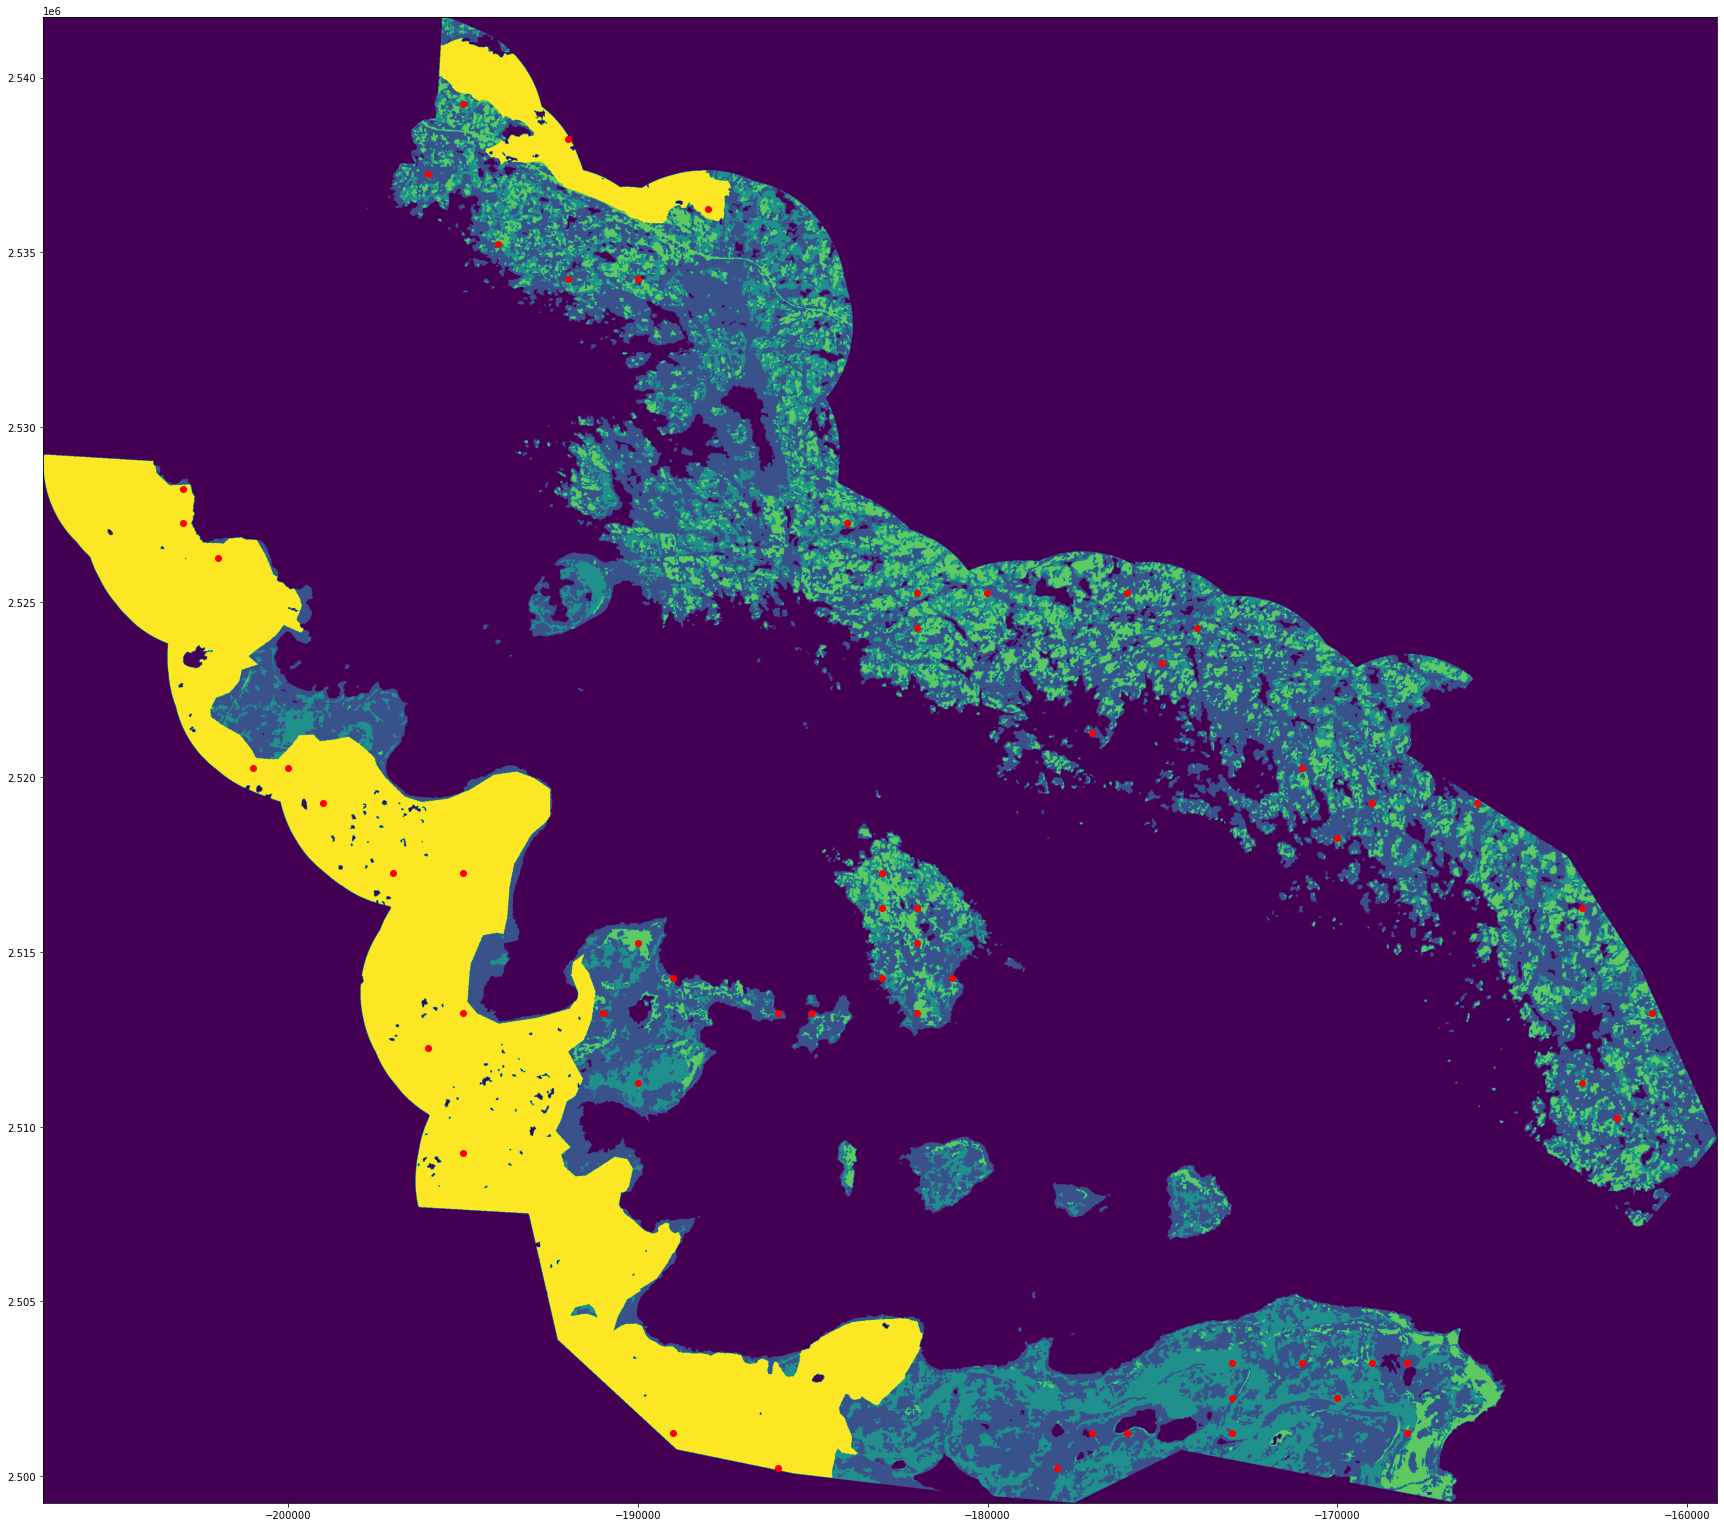

In [3]:
rcl_dic = {
    0: "nodata",
    1: "wetlands",
    2: "Forest",
    3: "Ground",
    4: "Burn"
}
roi_pa = r"D:\Julien\Projects\Dinaga_FW\Base_data\DinagaWekehodi_Dec2016_ILW_albers112.shp"
roi_full = r"D:\Julien\Projects\Dinaga_FW\Base_data\Dinaga_and_SLUP_albers112.shp"
ducks = r"D:\Julien\Data\Classification\DUCS\Dinaga_Wekehodi\DUC_Dinaga_Wekehodi_Classifications\CWCS_Dinaga.tif"

# points_creation(roi_pa, ducks, 15, rcl_dic, write_raster = 1)
points_creation(roi_full, ducks, 15, rcl_dic, write_raster = 1)